# 실습참여 파일 제출안내
- Task : 아이캠퍼스에서 실습용 파일 다운 받아서, 빈칸 채우기
- 파일명: lab05-학번.ipynb
- 아이캠퍼스에 제출
- 기한: 오늘 자정까지 (23:59)

# Overview: Lab 05 - Deep Learning Training Pipeline with PyTorch [Overview]
- HW review
- Lab
  0. Deep learning pipeline
  1. Node Classification
  2. Link Prediction
  3. Graph Classification (다음 시간에)


# HW review
- 항목 별 사례 설명 : 사례 당 8점 (총 24점)
    - 출처(1)	선정이유(2)	데이터(1)	input(1)	output(1)	layer(2)
      - 선정이유 모두 정답 처리 : 본래 의도는 논문 상에서 해당 모델을 선정한 이유 (model의 novelty, contribution 등)를 제시하길 바랬으나, 본인이 이 논문을 선택한 이유로 적은 경우가 종종 있었음. 애매하게 설명했다고 판단해서 모두 정답 처리
- 항목 별 적절한 사례 제시 : 사례 당 2점 (총 6점)
    - e.g., 제시한 논문은 graph classification인데, node classification으로 설명한 경우 감점

# 환경설정

In [1]:
import torch
print("PyTorch has version {}".format(torch.__version__))

PyTorch has version 1.12.1+cu113


In [2]:
# install dgl
# https://www.dgl.ai/pages/start.html

!pip install -q dgl-cu113 dglgo -f https://data.dgl.ai/wheels/repo.html

     |████████████████████████████████| 239.1 MB 22 kB/s 
     |████████████████████████████████| 63 kB 2.3 MB/s 
     |████████████████████████████████| 291 kB 29.8 MB/s 
     |████████████████████████████████| 52 kB 1.4 MB/s 
     |████████████████████████████████| 103 kB 70.3 MB/s 
     |████████████████████████████████| 109 kB 68.6 MB/s 
     |████████████████████████████████| 78 kB 8.0 MB/s 
     |████████████████████████████████| 45 kB 3.8 MB/s 
     |████████████████████████████████| 29.5 MB 1.2 MB/s 
     |████████████████████████████████| 41 kB 488 kB/s 
     |████████████████████████████████| 3.2 MB 43.4 MB/s 
     |████████████████████████████████| 500 kB 53.6 MB/s 
     |████████████████████████████████| 1.1 MB 65.3 MB/s 
     |████████████████████████████████| 84 kB 3.9 MB/s 
     |████████████████████████████████| 133 kB 72.6 MB/s 
     |████████████████████████████████| 100 kB 10.7 MB/s 
     |████████████████████████████████| 121 kB 72.1 MB/s 
     |████████████████████

# 0. Deep learning pipeline (참고: 4주차 수업자료 [딥러닝 기초] 5-1 ~ )

- **모델 정의**
- 데이터셋 및 데이터로더 정의
- **훈련 루프 정의**
- 평가 루프 정의

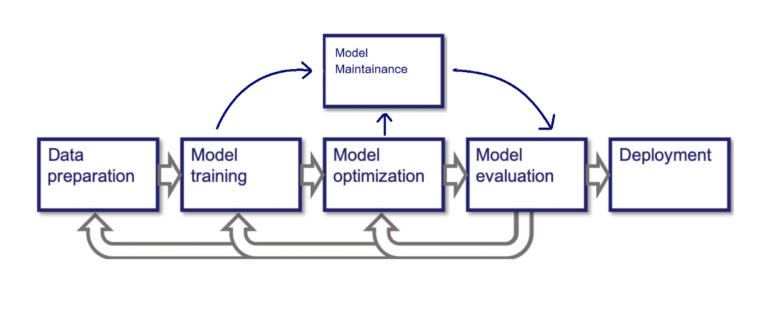
- 출처 : https://datatron.com/what-is-a-machine-learning-pipeline/

# 1. Node Classification

- Cora dataset
- task : 각 paper 별 주제 맞추기
- input : coraGraphdataset 
  - node: paper
  - edge : paper A - paper B (A가 B를 citation한 경우)
  - node feature :  sparse bag-of-words feature vectors for each document (1433)
- output : size 7의 vector (주제)
  - Theory
  - Reinforcement_Learning
  - Genetic_Algorithms
  - Neural_Networks
  - Probabilistic_Methods
  - Case_Based	
  - Rule_Learning	

In [3]:
import dgl
import torch
import torch.nn as nn
import torch.nn.functional as F

DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


### data load

In [4]:
# data load
import dgl.data

dataset = dgl.data.CoraGraphDataset()
print('Number of categories:', dataset.num_classes)

Extracting file to /root/.dgl/cora_v2
Finished data loading and preprocessing.
  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done saving data into cached files.
Number of categories: 7


In [5]:
g = dataset[0]
g

Graph(num_nodes=2708, num_edges=10556,
      ndata_schemes={'train_mask': Scheme(shape=(), dtype=torch.bool), 'val_mask': Scheme(shape=(), dtype=torch.bool), 'test_mask': Scheme(shape=(), dtype=torch.bool), 'label': Scheme(shape=(), dtype=torch.int64), 'feat': Scheme(shape=(1433,), dtype=torch.float32)}
      edata_schemes={})

In [ ]:
"""
train_mask: A boolean tensor indicating whether the node is in the training set. 
  => 왜 train이 140개뿐?
  => For training, we only use 20 labels per class, but all feature vectors (Kipf & Welling, Semi-Supervised Classification with Graph Convolutional Networks, 2016)

val_mask: A boolean tensor indicating whether the node is in the validation set.
test_mask: A boolean tensor indicating whether the node is in the test set.
label: The ground truth node category.
feat: The node features.
"""

In [6]:
print('Node features')
print(g.ndata)
print('Edge features')
print(g.edata)

Node features
{'train_mask': tensor([ True,  True,  True,  ..., False, False, False]), 'val_mask': tensor([False, False, False,  ..., False, False, False]), 'test_mask': tensor([False, False, False,  ...,  True,  True,  True]), 'label': tensor([3, 4, 4,  ..., 3, 3, 3]), 'feat': tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])}
Edge features
{}


In [7]:
print('train_mask')
print(g.ndata['train_mask'])

print('label')
print(g.ndata['label'])

print('feat')
print(g.ndata['feat'])
print(g.ndata['feat'].size())

train_mask
tensor([ True,  True,  True,  ..., False, False, False])
label
tensor([3, 4, 4,  ..., 3, 3, 3])
feat
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
torch.Size([2708, 1433])


In [8]:
 """
  - Theory
  - Reinforcement_Learning
  - Genetic_Algorithms
  - Neural_Networks
  - Probabilistic_Methods
  - Case_Based	
  - Rule_Learning	
  """

torch.bincount(g.ndata['label'])

tensor([351, 217, 418, 818, 426, 298, 180])

### Defining a Graph Convolutional Network (GCN)¶

- torch.nn.Module
  - torch에서 딥러닝 훈련에 필요한 모듈들 정의해놓은 서브 패키지
  - CNN layer, fully connected layer 등 딥러닝 훈련 알고리즘 정의

- __init__ 함수
  - __init__ 함수에서는 우리가 필요한 모듈들을 미리 설정

- forward 함수
  - training loop를 돌면서 들어오는 데이터에 대해, 미리 정의한 훈련 구조를 바탕으로 최종 계산값을 구해주는 역할

In [9]:
from dgl.nn import GraphConv

# GraphConv : GCN 구현 패키지 https://docs.dgl.ai/en/0.9.x/generated/dgl.nn.pytorch.conv.GraphConv.html# 

class GCN(nn.Module):
    def __init__(self, in_feats, h_feats, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GraphConv(in_feats, h_feats)
        self.conv2 = GraphConv(h_feats, num_classes)

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        return h

In [10]:
# Create the model with given dimensions
model = GCN(g.ndata['feat'].shape[1], 16, dataset.num_classes)
model

GCN(
  (conv1): GraphConv(in=1433, out=16, normalization=both, activation=None)
  (conv2): GraphConv(in=16, out=7, normalization=both, activation=None)
)

# Node Embedding
- model은 GCN 구조를 거쳐서 output 값 출력
- 다음은 GCN을 한번 거친 embedding visualization

In [11]:
# 시각화용 유틸함수 정의

%matplotlib inline
import torch
import networkx as nx
import matplotlib.pyplot as plt

# Visualization function for NX graph or PyTorch tensor
def visualize(h, color, epoch=None, loss=None):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])

    if torch.is_tensor(h):
        h = h.detach().cpu().numpy()
        plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
        if epoch is not None and loss is not None:
            plt.xlabel(f'Epoch: {epoch}, Loss: {loss.item():.4f}', fontsize=16)
    else:
        nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,
                         node_color=color, cmap="Set2")
    plt.show()

In [12]:
logits = model(g, g.ndata['feat'])
print(f'Embedding shape: {list(logits.shape)}')

Embedding shape: [2708, 7]


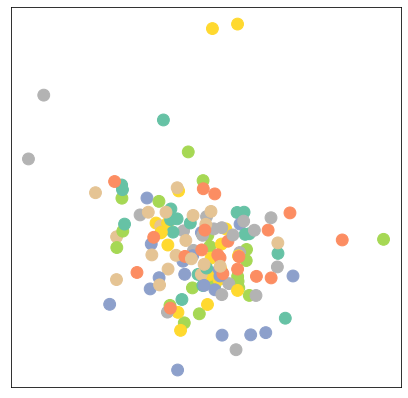

In [13]:
visualize(logits[g.ndata['train_mask']], color=g.ndata['label'][g.ndata['train_mask']])

In [14]:
g.ndata['label'][g.ndata['train_mask']]

tensor([3, 4, 4, 0, 3, 2, 0, 3, 3, 2, 0, 0, 4, 3, 3, 3, 2, 3, 1, 3, 5, 3, 4, 6,
        3, 3, 6, 3, 2, 4, 3, 6, 0, 4, 2, 0, 1, 5, 4, 4, 3, 6, 6, 4, 3, 3, 2, 5,
        3, 4, 5, 3, 0, 2, 1, 4, 6, 3, 2, 2, 0, 0, 0, 4, 2, 0, 4, 5, 2, 6, 5, 2,
        2, 2, 0, 4, 5, 6, 4, 0, 0, 0, 4, 2, 4, 1, 4, 6, 0, 4, 2, 4, 6, 6, 0, 0,
        6, 5, 0, 6, 0, 2, 1, 1, 1, 2, 6, 5, 6, 1, 2, 2, 1, 5, 5, 5, 6, 5, 6, 5,
        5, 1, 6, 6, 1, 5, 1, 6, 5, 5, 5, 1, 5, 1, 1, 1, 1, 1, 1, 1])

In [15]:
logits[g.ndata['train_mask']][0]

tensor([-0.0037,  0.0030,  0.0020, -0.0053,  0.0123, -0.0082,  0.0030],
       grad_fn=<SelectBackward0>)

### Training the GCN

- 훈련 루프 구성
    - `model.train()` : 모델 layer들의 동작을 train mode로 변경
    - `optimizer.zero_grad()`: gradients 초기화
    -  `logits = model(g, features)`: 모델의 input에 따른 output 구하기
    - `loss = F.cross_entropy(logits[train_mask], labels[train_mask])`: loss function을 이용해서 모델의 output과 실제 traget 사이의 loss 값 구하기
    - `loss.backward()`: loss 값을 이용한 gradeient 계산
    - `optimizer.step()`: 계산된 gradeient를 이용해서 모델 파라미터 업데이트

- 평가 루프 구성
    - `with torch.no_grad():`: autograd 종료 후 (=자동으로 gradient를 트래킹X) 메모리 사용량을 줄이고 연산 속도 높임
    - `model.eval()`: 모델 layer들의 동작을 inference(eval) mode로 변경 (train 시, test 시 모델 구조 다를 수 있음)

In [16]:
import time
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 430})'''))

<IPython.core.display.Javascript object>

In [17]:
def train(g,features,labels,train_mask,val_mask):
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    best_val_acc = 0

    # Forward
    logits = model(g, features)

    # Compute loss
    # Note that you should only compute the losses of the nodes in the training set.
    loss = F.cross_entropy(logits[train_mask], labels[train_mask])

    # Backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Compute prediction
    pred = logits.argmax(1)

    # Compute accuracy on training/validation/test
    train_acc = (pred[train_mask] == labels[train_mask]).float().mean()
    val_acc = (pred[val_mask] == labels[val_mask]).float().mean() # 정석은 model.eval() 해줘야함

    # Save the best validation accuracy and the corresponding test accuracy.
    if best_val_acc < val_acc:
        best_val_acc = val_acc

    return loss, logits, val_acc, best_val_acc

def test(g,features,labels,test_mask):
    with torch.no_grad():
      model.eval()
      logits = model(g, features)
      loss = F.cross_entropy(logits[test_mask], labels[test_mask])

      pred = logits.argmax(1)
      test_acc = (pred[test_mask] == labels[test_mask]).float().mean()

      return loss, pred, test_acc

In [18]:
def main(epoch, g, model):
    features = g.ndata['feat']
    labels = g.ndata['label']
    train_mask = g.ndata['train_mask']
    val_mask = g.ndata['val_mask']
    test_mask = g.ndata['test_mask']

    # train
    for e in range(epoch):
        loss, logits, val_acc, best_val_acc = train(g,features,labels,train_mask,val_mask)
        print('In epoch {}, loss: {:.3f}, val acc: {:.3f} (best {:.3f})'.format(
                e, loss, val_acc, best_val_acc))

        if e % 10 == 0:
            visualize(logits[val_mask], color=labels[val_mask], epoch=e, loss=loss)
            time.sleep(0.3)

    # test
    loss, pred, test_acc = test(g,features,labels,test_mask)
    print('[Test result] loss: {:.3f}, test acc: {:.3f}'.format(loss, test_acc))

In epoch 0, loss: 1.947, val acc: 0.134 (best 0.134)


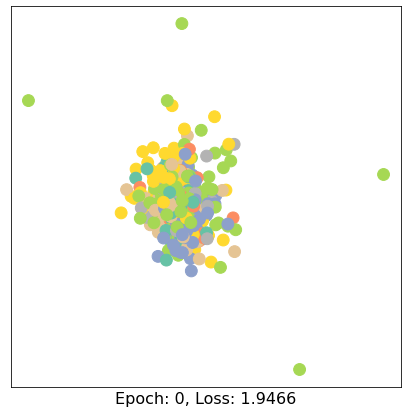

In epoch 1, loss: 1.940, val acc: 0.080 (best 0.080)
In epoch 2, loss: 1.929, val acc: 0.280 (best 0.280)
In epoch 3, loss: 1.915, val acc: 0.304 (best 0.304)
In epoch 4, loss: 1.902, val acc: 0.408 (best 0.408)
In epoch 5, loss: 1.886, val acc: 0.410 (best 0.410)
In epoch 6, loss: 1.871, val acc: 0.420 (best 0.420)
In epoch 7, loss: 1.853, val acc: 0.434 (best 0.434)
In epoch 8, loss: 1.837, val acc: 0.430 (best 0.430)
In epoch 9, loss: 1.818, val acc: 0.464 (best 0.464)
In epoch 10, loss: 1.799, val acc: 0.456 (best 0.456)


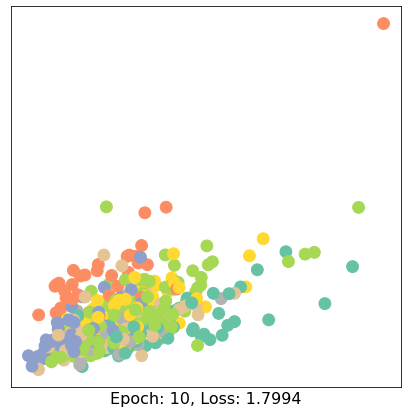

In epoch 11, loss: 1.779, val acc: 0.494 (best 0.494)
In epoch 12, loss: 1.758, val acc: 0.486 (best 0.486)
In epoch 13, loss: 1.736, val acc: 0.478 (best 0.478)
In epoch 14, loss: 1.714, val acc: 0.500 (best 0.500)
In epoch 15, loss: 1.691, val acc: 0.512 (best 0.512)
In epoch 16, loss: 1.667, val acc: 0.496 (best 0.496)
In epoch 17, loss: 1.643, val acc: 0.536 (best 0.536)
In epoch 18, loss: 1.618, val acc: 0.530 (best 0.530)
In epoch 19, loss: 1.593, val acc: 0.562 (best 0.562)
In epoch 20, loss: 1.567, val acc: 0.566 (best 0.566)


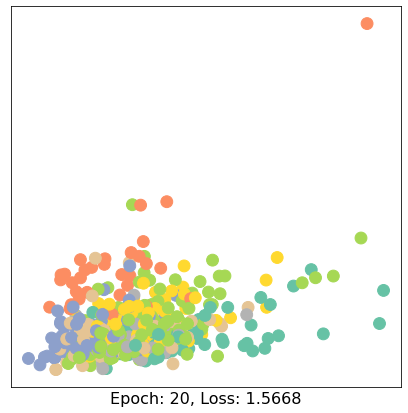

In epoch 21, loss: 1.541, val acc: 0.552 (best 0.552)
In epoch 22, loss: 1.514, val acc: 0.570 (best 0.570)
In epoch 23, loss: 1.487, val acc: 0.590 (best 0.590)
In epoch 24, loss: 1.459, val acc: 0.582 (best 0.582)
In epoch 25, loss: 1.431, val acc: 0.622 (best 0.622)
In epoch 26, loss: 1.403, val acc: 0.608 (best 0.608)
In epoch 27, loss: 1.374, val acc: 0.628 (best 0.628)
In epoch 28, loss: 1.345, val acc: 0.642 (best 0.642)
In epoch 29, loss: 1.317, val acc: 0.620 (best 0.620)
In epoch 30, loss: 1.287, val acc: 0.638 (best 0.638)


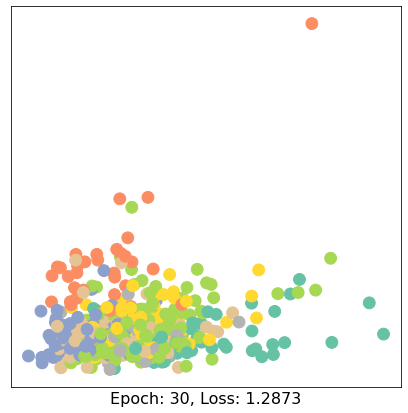

In epoch 31, loss: 1.258, val acc: 0.648 (best 0.648)
In epoch 32, loss: 1.229, val acc: 0.658 (best 0.658)
In epoch 33, loss: 1.199, val acc: 0.656 (best 0.656)
In epoch 34, loss: 1.170, val acc: 0.676 (best 0.676)
In epoch 35, loss: 1.140, val acc: 0.682 (best 0.682)
In epoch 36, loss: 1.111, val acc: 0.690 (best 0.690)
In epoch 37, loss: 1.081, val acc: 0.702 (best 0.702)
In epoch 38, loss: 1.052, val acc: 0.712 (best 0.712)
In epoch 39, loss: 1.023, val acc: 0.712 (best 0.712)
In epoch 40, loss: 0.995, val acc: 0.716 (best 0.716)


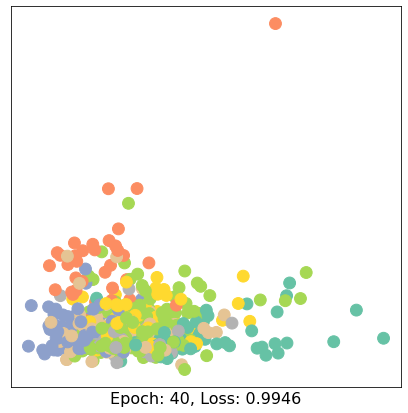

In epoch 41, loss: 0.966, val acc: 0.712 (best 0.712)
In epoch 42, loss: 0.937, val acc: 0.728 (best 0.728)
In epoch 43, loss: 0.910, val acc: 0.718 (best 0.718)
In epoch 44, loss: 0.881, val acc: 0.732 (best 0.732)
In epoch 45, loss: 0.854, val acc: 0.734 (best 0.734)
In epoch 46, loss: 0.827, val acc: 0.740 (best 0.740)
In epoch 47, loss: 0.800, val acc: 0.742 (best 0.742)
In epoch 48, loss: 0.774, val acc: 0.740 (best 0.740)
In epoch 49, loss: 0.748, val acc: 0.738 (best 0.738)
In epoch 50, loss: 0.722, val acc: 0.750 (best 0.750)


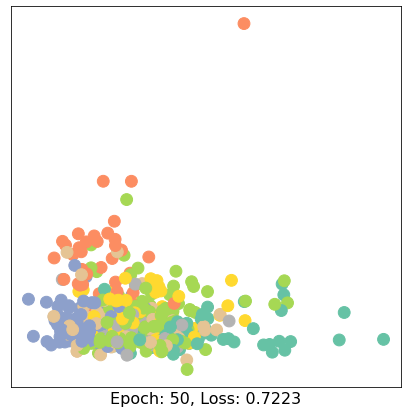

In epoch 51, loss: 0.697, val acc: 0.746 (best 0.746)
In epoch 52, loss: 0.673, val acc: 0.750 (best 0.750)
In epoch 53, loss: 0.649, val acc: 0.746 (best 0.746)
In epoch 54, loss: 0.625, val acc: 0.752 (best 0.752)
In epoch 55, loss: 0.602, val acc: 0.748 (best 0.748)
In epoch 56, loss: 0.579, val acc: 0.758 (best 0.758)
In epoch 57, loss: 0.558, val acc: 0.746 (best 0.746)
In epoch 58, loss: 0.536, val acc: 0.752 (best 0.752)
In epoch 59, loss: 0.516, val acc: 0.756 (best 0.756)
In epoch 60, loss: 0.495, val acc: 0.762 (best 0.762)


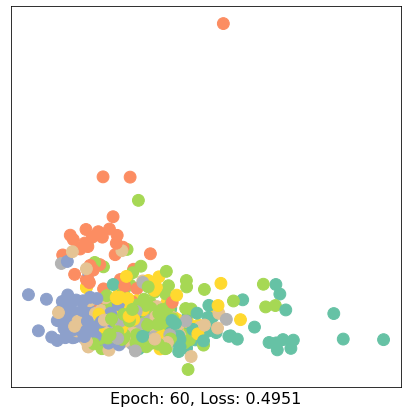

In epoch 61, loss: 0.476, val acc: 0.756 (best 0.756)
In epoch 62, loss: 0.457, val acc: 0.764 (best 0.764)
In epoch 63, loss: 0.438, val acc: 0.760 (best 0.760)
In epoch 64, loss: 0.421, val acc: 0.762 (best 0.762)
In epoch 65, loss: 0.402, val acc: 0.764 (best 0.764)
In epoch 66, loss: 0.385, val acc: 0.774 (best 0.774)
In epoch 67, loss: 0.369, val acc: 0.766 (best 0.766)
In epoch 68, loss: 0.354, val acc: 0.778 (best 0.778)
In epoch 69, loss: 0.338, val acc: 0.766 (best 0.766)
In epoch 70, loss: 0.324, val acc: 0.776 (best 0.776)


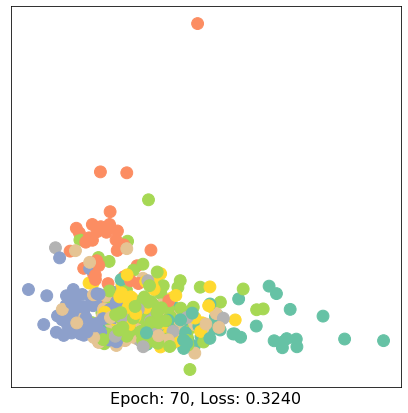

In epoch 71, loss: 0.310, val acc: 0.766 (best 0.766)
In epoch 72, loss: 0.296, val acc: 0.776 (best 0.776)
In epoch 73, loss: 0.283, val acc: 0.768 (best 0.768)
In epoch 74, loss: 0.270, val acc: 0.780 (best 0.780)
In epoch 75, loss: 0.258, val acc: 0.770 (best 0.770)
In epoch 76, loss: 0.246, val acc: 0.782 (best 0.782)
In epoch 77, loss: 0.234, val acc: 0.776 (best 0.776)
In epoch 78, loss: 0.223, val acc: 0.780 (best 0.780)
In epoch 79, loss: 0.212, val acc: 0.776 (best 0.776)
In epoch 80, loss: 0.202, val acc: 0.782 (best 0.782)


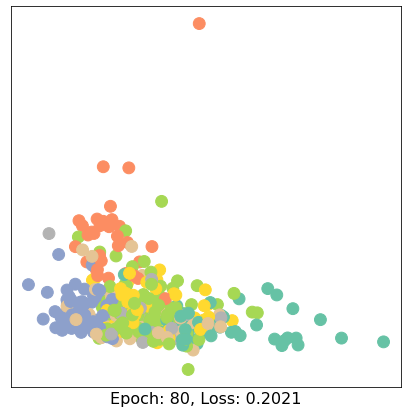

In epoch 81, loss: 0.192, val acc: 0.778 (best 0.778)
In epoch 82, loss: 0.183, val acc: 0.780 (best 0.780)
In epoch 83, loss: 0.174, val acc: 0.776 (best 0.776)
In epoch 84, loss: 0.165, val acc: 0.782 (best 0.782)
In epoch 85, loss: 0.157, val acc: 0.778 (best 0.778)
In epoch 86, loss: 0.149, val acc: 0.782 (best 0.782)
In epoch 87, loss: 0.142, val acc: 0.778 (best 0.778)
In epoch 88, loss: 0.135, val acc: 0.782 (best 0.782)
In epoch 89, loss: 0.128, val acc: 0.778 (best 0.778)
In epoch 90, loss: 0.121, val acc: 0.786 (best 0.786)


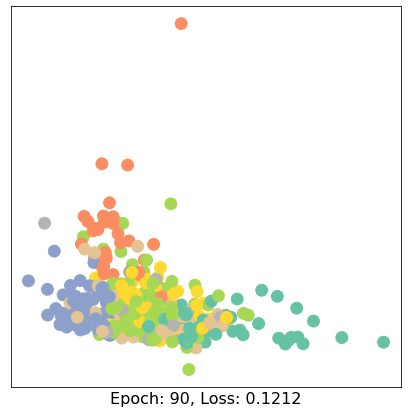

In epoch 91, loss: 0.115, val acc: 0.780 (best 0.780)
In epoch 92, loss: 0.109, val acc: 0.788 (best 0.788)
In epoch 93, loss: 0.103, val acc: 0.782 (best 0.782)
In epoch 94, loss: 0.097, val acc: 0.788 (best 0.788)
In epoch 95, loss: 0.092, val acc: 0.782 (best 0.782)
In epoch 96, loss: 0.087, val acc: 0.788 (best 0.788)
In epoch 97, loss: 0.082, val acc: 0.784 (best 0.784)
In epoch 98, loss: 0.078, val acc: 0.790 (best 0.790)
In epoch 99, loss: 0.073, val acc: 0.778 (best 0.778)
[Test result] loss: 0.801, test acc: 0.761


In [19]:
model = GCN(g.ndata['feat'].shape[1], 16, dataset.num_classes)
main(100,g,model)

In [20]:
# training on GPU
g = g.to('cuda')
model = GCN(g.ndata['feat'].shape[1], 16, dataset.num_classes).to('cuda')

# 2. Link Prediction

- Cora dataset
- task : paper 간 citation link 연결 되는지 (link prediction requires you to compute representation of pairs of nodes.)
- input :
  - coraGraphdataset
    - Positive graph : Graph에 존재하는 edge
    - negative graph : Graph에 존재하지 않는 edge
- output : probability of existence of an edge
- objective function : 
    - 노드 u와 v 간의 score가 노드 u와 v'간의 score 보다 높도록 학습 (== negative sampling)

In [21]:
import dgl
import torch
import torch.nn as nn
import torch.nn.functional as F
import itertools
import numpy as np
import scipy.sparse as sp

### data load & prepare trainig and testing sets

In [22]:
import dgl.data

dataset = dgl.data.CoraGraphDataset()
g = dataset[0]

  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.


### Positive graph, negative graph

In [23]:
# Split edge set for training and testing
u, v = g.edges() # source, target edges

eids = np.arange(g.number_of_edges()) 
eids = np.random.permutation(eids) # Randomly permute a sequence, or return a permuted range.
test_size = int(len(eids) * 0.1) # 10% 를 test로 설정
train_size = g.number_of_edges() - test_size
test_pos_u, test_pos_v = u[eids[:test_size]], v[eids[:test_size]]
train_pos_u, train_pos_v = u[eids[test_size:]], v[eids[test_size:]]

# Find all negative edges and split them for training and testing
adj = sp.coo_matrix((np.ones(len(u)), (u.numpy(), v.numpy())))
adj_neg = 1 - adj.todense() - np.eye(g.number_of_nodes()) # self loop, 자기 자신를 향하는 edge(예, (0, 0)의 경우)도 제외
neg_u, neg_v = np.where(adj_neg != 0) # 0 값이 아닌 edge 정보 추출

neg_eids = np.random.choice(len(neg_u), g.number_of_edges()) # g의 edge 수만큼 sampling
test_neg_u, test_neg_v = neg_u[neg_eids[:test_size]], neg_v[neg_eids[:test_size]] 
train_neg_u, train_neg_v = neg_u[neg_eids[test_size:]], neg_v[neg_eids[test_size:]]

# pos, neg graph 
train_pos_g = dgl.graph((train_pos_u, train_pos_v), num_nodes=g.number_of_nodes())
train_neg_g = dgl.graph((train_neg_u, train_neg_v), num_nodes=g.number_of_nodes())

test_pos_g = dgl.graph((test_pos_u, test_pos_v), num_nodes=g.number_of_nodes())
test_neg_g = dgl.graph((test_neg_u, test_neg_v), num_nodes=g.number_of_nodes())

# train, test graph
train_g = dgl.remove_edges(g, eids[:test_size])
test_g = dgl.remove_edges(g, eids[test_size:])

#### in detail

In [24]:
g.edges()

(tensor([   0,    0,    0,  ..., 2707, 2707, 2707]),
 tensor([ 633, 1862, 2582,  ...,  598, 1473, 2706]))

In [25]:
np.arange(g.number_of_edges())

array([    0,     1,     2, ..., 10553, 10554, 10555])

In [26]:
np.random.permutation(eids) # 순서만 랜덤으로

array([1447, 6801, 4724, ..., 5358, 3886, 7735])

In [27]:
len(np.arange(g.number_of_edges())), len(np.random.permutation(eids)) #안에 내용은 같음

(10556, 10556)

In [28]:
adj = sp.coo_matrix((np.ones(len(u)), (u.numpy(), v.numpy())))

In [29]:
adj.todense()

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 1., 0.]])

In [30]:
adj.todense()- np.eye(g.number_of_nodes())

matrix([[-1.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0., -1.,  1., ...,  0.,  0.,  0.],
        [ 0.,  1., -1., ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0., ..., -1.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0., -1.,  1.],
        [ 0.,  0.,  0., ...,  0.,  1., -1.]])

In [31]:
1 - adj.todense() - np.eye(g.number_of_nodes())

matrix([[0., 1., 1., ..., 1., 1., 1.],
        [1., 0., 0., ..., 1., 1., 1.],
        [1., 0., 0., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 0., 1., 1.],
        [1., 1., 1., ..., 1., 0., 0.],
        [1., 1., 1., ..., 1., 0., 0.]])

In [32]:
np.where(adj_neg != 0)

(array([   0,    0,    0, ..., 2707, 2707, 2707]),
 array([   1,    2,    3, ..., 2703, 2704, 2705]))

In [33]:
len(neg_u)

7320000

In [34]:
train_g

Graph(num_nodes=2708, num_edges=9501,
      ndata_schemes={'feat': Scheme(shape=(1433,), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.int64), 'test_mask': Scheme(shape=(), dtype=torch.bool), 'train_mask': Scheme(shape=(), dtype=torch.bool), 'val_mask': Scheme(shape=(), dtype=torch.bool)}
      edata_schemes={})

In [35]:
test_g

Graph(num_nodes=2708, num_edges=1055,
      ndata_schemes={'feat': Scheme(shape=(1433,), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.int64), 'test_mask': Scheme(shape=(), dtype=torch.bool), 'train_mask': Scheme(shape=(), dtype=torch.bool), 'val_mask': Scheme(shape=(), dtype=torch.bool)}
      edata_schemes={})

### Define a GraphSAGE model¶

In [36]:
from dgl.nn import SAGEConv

# build a two-layer GraphSAGE model
class GraphSAGE(nn.Module):
    def __init__(self, in_feats, h_feats):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_feats, h_feats, 'mean')
        self.conv2 = SAGEConv(h_feats, h_feats, 'mean')

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        return h

### Trainig loop

In [37]:
import dgl.function as fn

# 계산 방식 다양
class DotPredictor(nn.Module):
    def forward(self, g, h):
        with g.local_scope():
            g.ndata['h'] = h
            # Compute a new edge feature named 'score' by a dot-product between the
            # source node feature 'h' and destination node feature 'h'.
            g.apply_edges(fn.u_dot_v('h', 'h', 'score')) # u와 v를 element-wise dot 하고, 이 값을 변수명 score로 지정
            # u_dot_v returns a 1-element vector for each edge so you need to squeeze it.
            return g.edata['score'][:, 0]

In [38]:
def compute_loss(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score])
    labels = torch.cat([torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])])
    return F.binary_cross_entropy_with_logits(scores, labels)

def compute_auc(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score]).numpy()
    labels = torch.cat(
        [torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]).numpy()
    return roc_auc_score(labels, scores)

In [39]:
def train(train_g):
    model.train()
    optimizer = torch.optim.Adam(itertools.chain(model.parameters(), pred.parameters()), lr=0.01)
    h = model(train_g, train_g.ndata['feat'])
    pos_score = pred(train_pos_g, h)
    neg_score = pred(train_neg_g, h)
    loss = compute_loss(pos_score, neg_score)

    # backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss

In [40]:
from sklearn.metrics import roc_auc_score

epoch = 100
model = GraphSAGE(train_g.ndata['feat'].shape[1], 16)
pred = DotPredictor()

# train
for e in range(epoch):
    loss = train(train_g)
    if e % 10 == 0:
        print('In epoch {}, loss: {}'.format(e, loss))

# test
with torch.no_grad():
    model.eval()
    h = model(test_g, test_g.ndata['feat'])
    pos_score = pred(test_pos_g, h)
    neg_score = pred(test_neg_g, h)
    print('AUC', compute_auc(pos_score, neg_score))

In epoch 0, loss: 0.6929271817207336
In epoch 10, loss: 0.6024604439735413
In epoch 20, loss: 0.5330215096473694
In epoch 30, loss: 0.5228286981582642
In epoch 40, loss: 0.5161524415016174
In epoch 50, loss: 0.5101664066314697
In epoch 60, loss: 0.5042997598648071
In epoch 70, loss: 0.4990660846233368
In epoch 80, loss: 0.4941117465496063
In epoch 90, loss: 0.4893398880958557
AUC 0.8916493340221469


In [41]:
import copy

temp = copy.deepcopy(g)
temp.ndata['h'] = h
temp.apply_edges(fn.u_dot_v('h', 'h', 'score'))

In [42]:
temp

Graph(num_nodes=2708, num_edges=10556,
      ndata_schemes={'feat': Scheme(shape=(1433,), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.int64), 'test_mask': Scheme(shape=(), dtype=torch.bool), 'train_mask': Scheme(shape=(), dtype=torch.bool), 'val_mask': Scheme(shape=(), dtype=torch.bool), 'h': Scheme(shape=(16,), dtype=torch.float32)}
      edata_schemes={'score': Scheme(shape=(1,), dtype=torch.float32)})

In [43]:
g

Graph(num_nodes=2708, num_edges=10556,
      ndata_schemes={'feat': Scheme(shape=(1433,), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.int64), 'test_mask': Scheme(shape=(), dtype=torch.bool), 'train_mask': Scheme(shape=(), dtype=torch.bool), 'val_mask': Scheme(shape=(), dtype=torch.bool)}
      edata_schemes={})

In [44]:
pos_score

tensor([0.1114, 0.6293, 0.9732,  ..., 0.4290, 1.1482, 1.9453])

In [45]:
neg_score

tensor([-0.3124, -0.0987,  0.1178,  ..., -0.2917, -0.0100, -0.0403])

In [46]:
scores = torch.cat([pos_score, neg_score])
scores.size()

torch.Size([2110])

# 3. Graph Classification
- 다음시간에

# 실습
- 빈칸 채우기

In [47]:
# 시각화용 유틸함수 정의

%matplotlib inline
import torch
import networkx as nx
import matplotlib.pyplot as plt

# Visualization function for NX graph or PyTorch tensor
def visualize(h, color, epoch=None, loss=None):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])

    if torch.is_tensor(h):
        h = h.detach().cpu().numpy()
        plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
        if epoch is not None and loss is not None:
            plt.xlabel(f'Epoch: {epoch}, Loss: {loss.item():.4f}', fontsize=16)
    else:
        nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,
                         node_color=color, cmap="Set2")
    plt.show()

In [48]:
from dgl.nn import GraphConv

class GCN(nn.Module):
    def __init__(self, in_feats, h_feats, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GraphConv(in_feats, h_feats)
        self.conv2 = GraphConv(h_feats, num_classes)

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        return h

In [49]:
# data load
import dgl.data

dataset = dgl.data.CoraGraphDataset()
g = dataset[0]

  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.


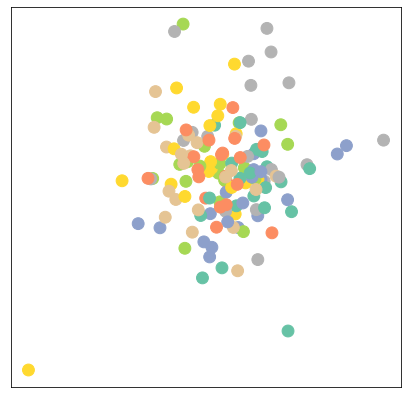

In [50]:
## 빈칸채우기

model = GCN(g.ndata['feat'].shape[1], 16, dataset.num_classes)
logits = logits = model(g, g.ndata['feat'])

visualize(logits[g.ndata['train_mask']], color=g.ndata['label'][g.ndata['train_mask']])